##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [2]:
#%pip install pandas 
#%pip install matplotlib
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [3]:
# Can have as many cells as you want for code
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
filepath = "./data/catB_train.parquet" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [4]:
df = pd.read_parquet(filepath)
print(df.dtypes)

clntnum                      object
race_desc                    object
ctrycode_desc                object
clttype                      object
stat_flag                    object
                             ...   
flg_gi_claim_29d435_ever     object
flg_gi_claim_058815_ever     object
flg_gi_claim_42e115_ever     object
flg_gi_claim_856320_ever     object
f_purchase_lh               float64
Length: 304, dtype: object


### 1. Data Exploration

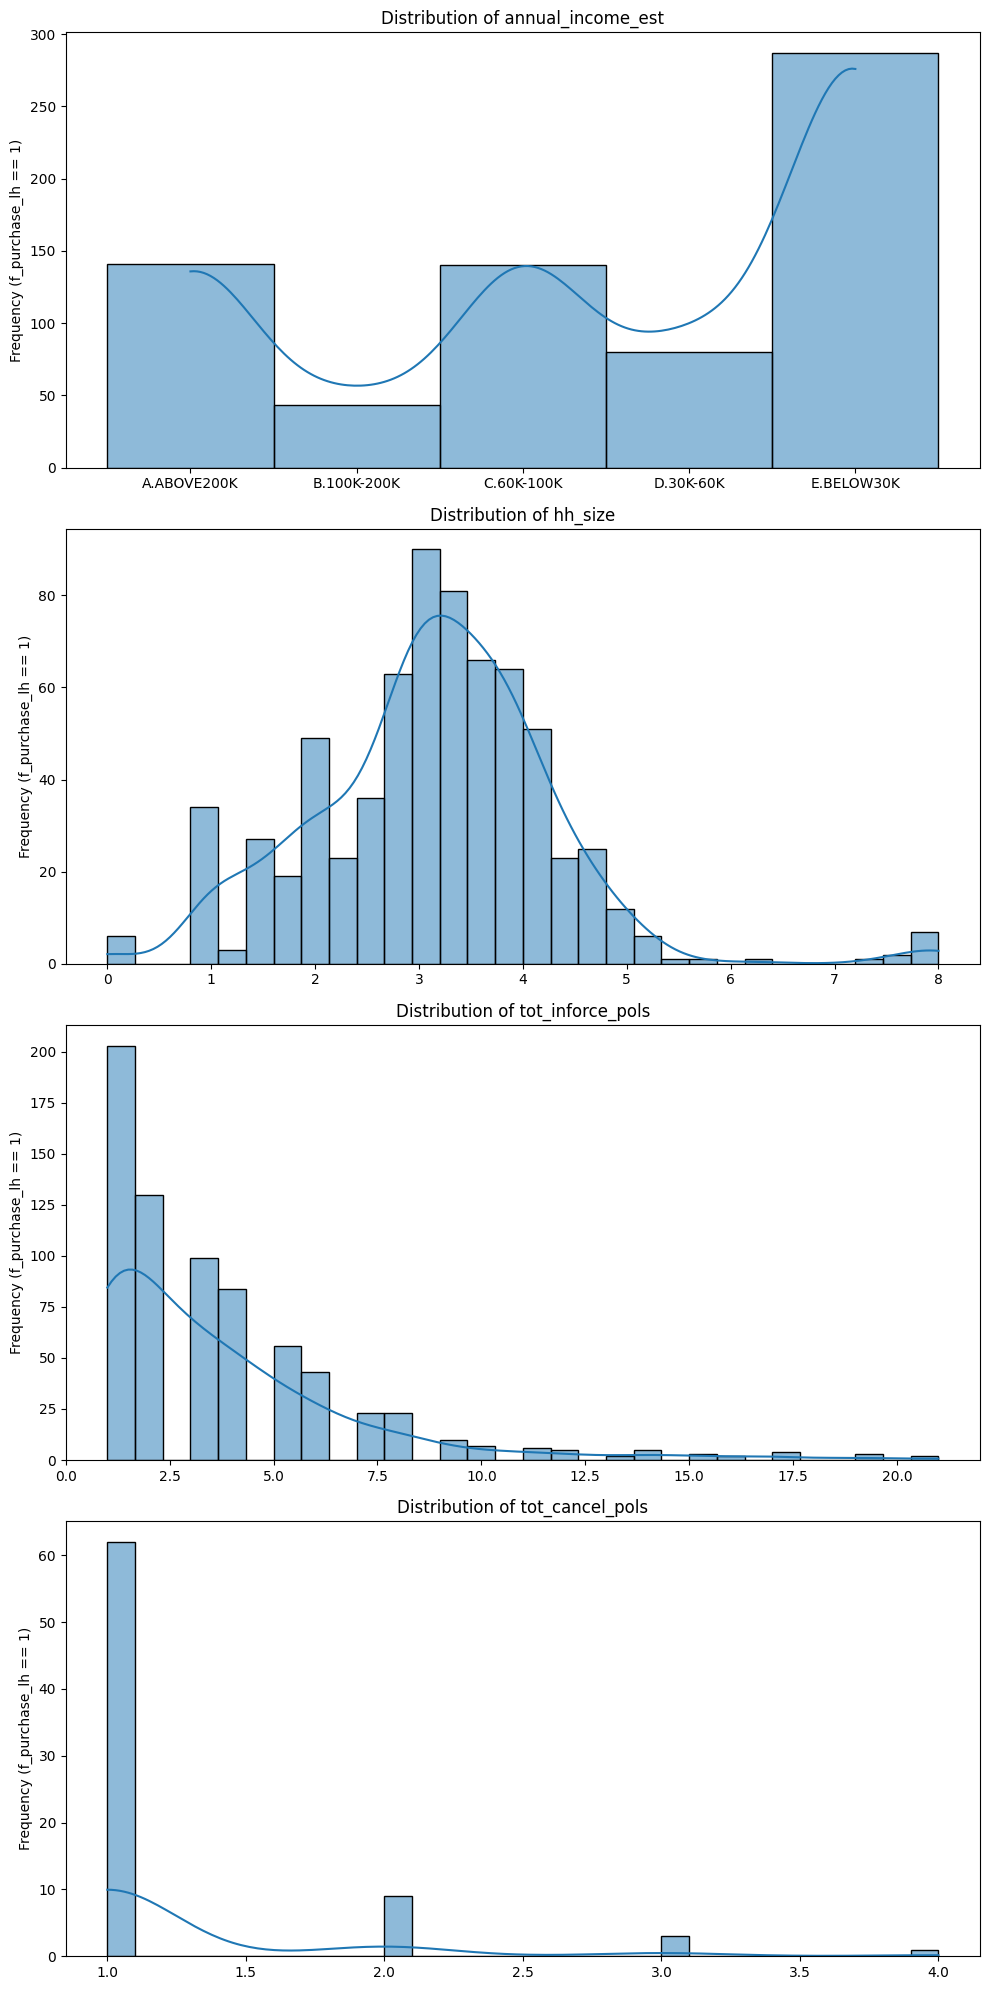

In [9]:
# Filtering the DataFrame where 'f_purchase_lh' equals 1
filtered_df = df[df['f_purchase_lh'] == 1].copy()

# Plotting distributions of continuous columns based on the filtered DataFrame
continuous_cols = ['annual_income_est', 'hh_size', 'tot_inforce_pols', 'tot_cancel_pols']
fig, axes = plt.subplots(len(continuous_cols), 1, figsize=(10, 5 * len(continuous_cols)))

for i, col in enumerate(continuous_cols):
    if col == 'annual_income_est':
        # Sorting categories lexicographically for 'annual_income_est'
        sorted_categories = sorted(filtered_df[col].dropna().unique())
        filtered_df[col] = pd.Categorical(filtered_df[col], categories=sorted_categories, ordered=True)
        sns.histplot(filtered_df[col], bins=len(sorted_categories), kde=True, ax=axes[i])
    else:
        # Plotting histograms for other continuous columns
        sns.histplot(filtered_df[col], bins=30, kde=True, ax=axes[i])
    
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frequency (f_purchase_lh == 1)')

plt.tight_layout()
plt.show()

### 2. Data Cleaning

In [52]:
# Convert target col to 0 or 1 (binary)
df["f_purchase_lh"].fillna(0, inplace=True)

clntnum                      object
race_desc                    object
ctrycode_desc                object
clttype                      object
stat_flag                    object
                             ...   
flg_gi_claim_29d435_ever     object
flg_gi_claim_058815_ever     object
flg_gi_claim_42e115_ever     object
flg_gi_claim_856320_ever     object
f_purchase_lh               float64
Length: 304, dtype: object


#### A. General Client Information

In [53]:
#imputing missing values for client information
clnt_info_columns = ['race_desc', 'ctrycode_desc', 'cltsex_fix', 'clntnum', 'clttype', 'stat_flag', 'min_occ_date', 'cltdob_fix']

for clnt_info_column in clnt_info_columns:
    df[clnt_info_column] = df[clnt_info_column].fillna(df[clnt_info_column].mode()[0])

df[['race_desc', 'ctrycode_desc', 'cltsex_fix', 'stat_flag', 'clttype']].isna().sum()

race_desc        0
ctrycode_desc    0
cltsex_fix       0
stat_flag        0
clttype          0
dtype: int64

#### B. Client Risk and Status Indicators

In [54]:
#imputing missing client risk and status indicator
clnt_risk_status_columns = ['flg_substandard', 'flg_is_borderline_standard', 'flg_is_revised_term', 'flg_is_rental_flat', 'flg_has_health_claim', 'flg_has_life_claim', 'flg_gi_claim', 'flg_is_proposal', 'flg_with_preauthorisation', 'flg_is_returned_mail']

for clnt_risk_status_column in clnt_risk_status_columns:
    df[clnt_risk_status_column] = df[clnt_risk_status_column].fillna(df[clnt_risk_status_column].mode()[0])

df[['flg_substandard', 'flg_is_borderline_standard', 'flg_is_revised_term', 'flg_is_rental_flat', 'flg_has_health_claim', 'flg_has_life_claim', 'flg_gi_claim', 'flg_is_proposal', 'flg_with_preauthorisation', 'flg_is_returned_mail']].isna().sum()

flg_substandard               0
flg_is_borderline_standard    0
flg_is_revised_term           0
flg_is_rental_flat            0
flg_has_health_claim          0
flg_has_life_claim            0
flg_gi_claim                  0
flg_is_proposal               0
flg_with_preauthorisation     0
flg_is_returned_mail          0
dtype: int64

#### C. Client Consent and Communication Preferences

In [55]:
#imputing missing client consent and communication preferences
clnt_consent_columns = ['is_consent_to_mail', 'is_consent_to_email', 'is_consent_to_call', 'is_consent_to_sms', 'is_valid_dm', 'is_valid_email']

for clnt_consent_column in clnt_consent_columns:
    df[clnt_consent_column] = df[clnt_consent_column].fillna(df[clnt_consent_column].mode()[0])

df[['is_consent_to_mail', 'is_consent_to_email', 'is_consent_to_call', 'is_consent_to_sms', 'is_valid_dm', 'is_valid_email']].isna().sum()

is_consent_to_mail     0
is_consent_to_email    0
is_consent_to_call     0
is_consent_to_sms      0
is_valid_dm            0
is_valid_email         0
dtype: int64

#### D. Policy and Claim History

In [56]:
#flg_latest_being_lapse, flg_latest_being_cancel, tot_inforce_pols do not have missing values
empty_val_check = df[['flg_latest_being_lapse','flg_latest_being_cancel','tot_inforce_pols']]
empty_val_check.isna().sum().sum()

0

In [57]:
#imputing negative values for n_months_last_bought_products, no missing values
median_without_negatives = df['n_months_last_bought_products'][df['n_months_last_bought_products'] >= 0].median()

df['n_months_last_bought_products'] = df['n_months_last_bought_products'].apply(lambda x: x if x >= 0 else median_without_negatives)

#imputing recency_lapse with 9999 if flg_latest_being_lapse == 0, otherwise median 
df.loc[df['flg_latest_being_lapse'] == 0, 'recency_lapse'] = 9999
df.loc[(df['flg_latest_being_lapse'] == 1) & (df['recency_lapse'].isna()), 'recency_lapse'] = 0
df['flg_latest_being_lapse'].isna().sum()

#doing the same for cancellations
df.loc[df['flg_latest_being_cancel'] == 0, 'recency_cancel'] = 9999
df.loc[(df['flg_latest_being_cancel'] == 1) & (df['recency_cancel'].isna()), 'recency_cancel'] = 0
df['flg_latest_being_cancel'].isna().sum()

#tot_inforce_pols has no missing values

#imputing missing values of tot_cancel_pols
df.loc[df['flg_latest_being_cancel'] == 0, 'tot_cancel_pols'] = 0
df.loc[(df['tot_cancel_pols'].isna()) & (df['flg_latest_being_cancel'] == 1), 'tot_cancel_pols'] = 1

#imputing missing values of f_ever_declined_la
df['f_ever_declined_la'].fillna(0, inplace=True)

#### E. Demographic and Household Information, and Other Flags and Metrics

In [66]:
# Convert the data type of the column to the correct data type
df['hh_size_est'].replace('>4', 5, inplace=True)
df['hh_size_est'] = pd.to_numeric(df['hh_size_est'], errors='coerce')

income_mapping = {
    'A.ABOVE200K': 200001,  
    'B.100K-200K': 150000,  
    'C.60K-100K': 80000,
    'D.30K-60K': 45000,
    'E.BELOW30K': 15000
}

# Apply the mapping to the 'annual_income' column
df['annual_income_est'].replace(income_mapping, inplace=True)

# Fill in missing values with the median 
col_names_fill_median = ['hh_20', 'pop_20', 'hh_size', 'hh_size_est', 'annual_income_est']

for c in col_names_fill_median:
    df[c] = pd.to_numeric(df[c], errors='coerce')
    median_value = df[c].median()
    df[c].fillna(median_value, inplace=True)

# Fill in missing values with the mode 
col_names_fill_mode = ['is_housewife_retiree', 'is_sg_pr', 'is_class_1_2', 'is_dependent_in_at_least_1_policy']

for c in col_names_fill_mode:
    mode_value = df[c].mode()[0]
    df[c].fillna(mode_value, inplace=True)

# Fill in missing values with 0
col_names_fill_zero = ['flg_affconnect_show_interest_ever', 'flg_affconnect_ready_to_buy_ever', 'flg_affconnect_lapse_ever', 'affcon_visit_days', 'clmcon_visit_days']
for c in col_names_fill_zero:
    df[c].fillna(0, inplace=True)

for c in df.loc[:, 'hlthclaim_amt':'flg_gi_claim_856320_ever']:
    df[c].fillna(0, inplace=True)

# Fill in missing values with 9999
col_names_fill_9999 = ['n_months_since_visit_affcon', 'recency_clmcon', 'recency_clmcon_regis']
for c in col_names_fill_9999:
    df[c].fillna(9999, inplace=True)

In [67]:
df.head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,...,recency_giclaim,giclaim_cnt_success,recency_giclaim_success,giclaim_cnt_unsuccess,recency_giclaim_unsuccess,flg_gi_claim_29d435_ever,flg_gi_claim_058815_ever,flg_gi_claim_42e115_ever,flg_gi_claim_856320_ever,f_purchase_lh
19550,91b546e924,Chinese,Singapore,P,ACTIVE,2017-10-31,1974-05-09,Female,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0.0
4600,896bae548c,Chinese,Singapore,P,ACTIVE,2007-05-23,1979-11-11,Male,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0.0
13337,f364439ae6,Others,Singapore,P,ACTIVE,2019-08-31,1976-01-28,Male,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0.0
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,2021-10-18,1976-03-19,Female,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0.0
19724,2647a81328,Chinese,Singapore,P,ACTIVE,2018-07-20,1995-07-31,Female,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0.0


#### Cleaning Purchase and Lapse Metrics for Specific Products

In [30]:
# Checking number of empty values in lapse data
lapse_specific = df.loc[:, 'lapse_ape_ltc_1280bf':'n_months_since_lapse_32c74c']
lapse_specific.isna().sum().sum()

629600

In [31]:
# Fill in missing values with 0 for lapses
for column in df.loc[:, 'lapse_ape_ltc_1280bf':'lapse_ape_32c74c']:
    df[column] = df[column].fillna(0)

# Fill in missing values with 9999 for n_months_since_lapse
for column in df.loc[:, 'n_months_since_lapse_ltc_1280bf':'n_months_since_lapse_32c74c']:
    df[column] = df[column].fillna(9999)

df['n_months_since_lapse_ltc_1280bf'][13337] # checking

9999

In [32]:
# Checking number of empty values in purchase data
purchase_specific = df.loc[:, 'f_ever_bought_839f8a':'n_months_last_bought_32c74c']
purchase_specific.isna().sum().sum() # 0 -> no missing values

0

### 3. Checking for Duplicate Rows

In [25]:
duplicated_clntnum_count = df['clntnum'].duplicated(keep=False).sum()
print(f"Number of duplicated 'clntnum' values: {duplicated_clntnum_count}")

Number of duplicated 'clntnum' values: 0


### 4. Feature Selection

In [68]:
y = df['f_purchase_lh']
X = df.drop(columns=['f_purchase_lh'])

In [78]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
non_numeric_cols = df.select_dtypes(include=["string", "object"]).columns

df = df.drop(columns=non_numeric_cols)

In [79]:
df.head()

,flg_substandard,flg_is_borderline_standard,flg_is_revised_term,flg_is_rental_flat,flg_has_health_claim,flg_has_life_claim,flg_gi_claim,flg_is_proposal,flg_with_preauthorisation,flg_is_returned_mail,...,recency_giclaim,giclaim_cnt_success,recency_giclaim_success,giclaim_cnt_unsuccess,recency_giclaim_unsuccess,flg_gi_claim_29d435_ever,flg_gi_claim_058815_ever,flg_gi_claim_42e115_ever,flg_gi_claim_856320_ever,f_purchase_lh
19550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0.0
4600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0.0
13337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0.0
15074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0.0
19724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0.0


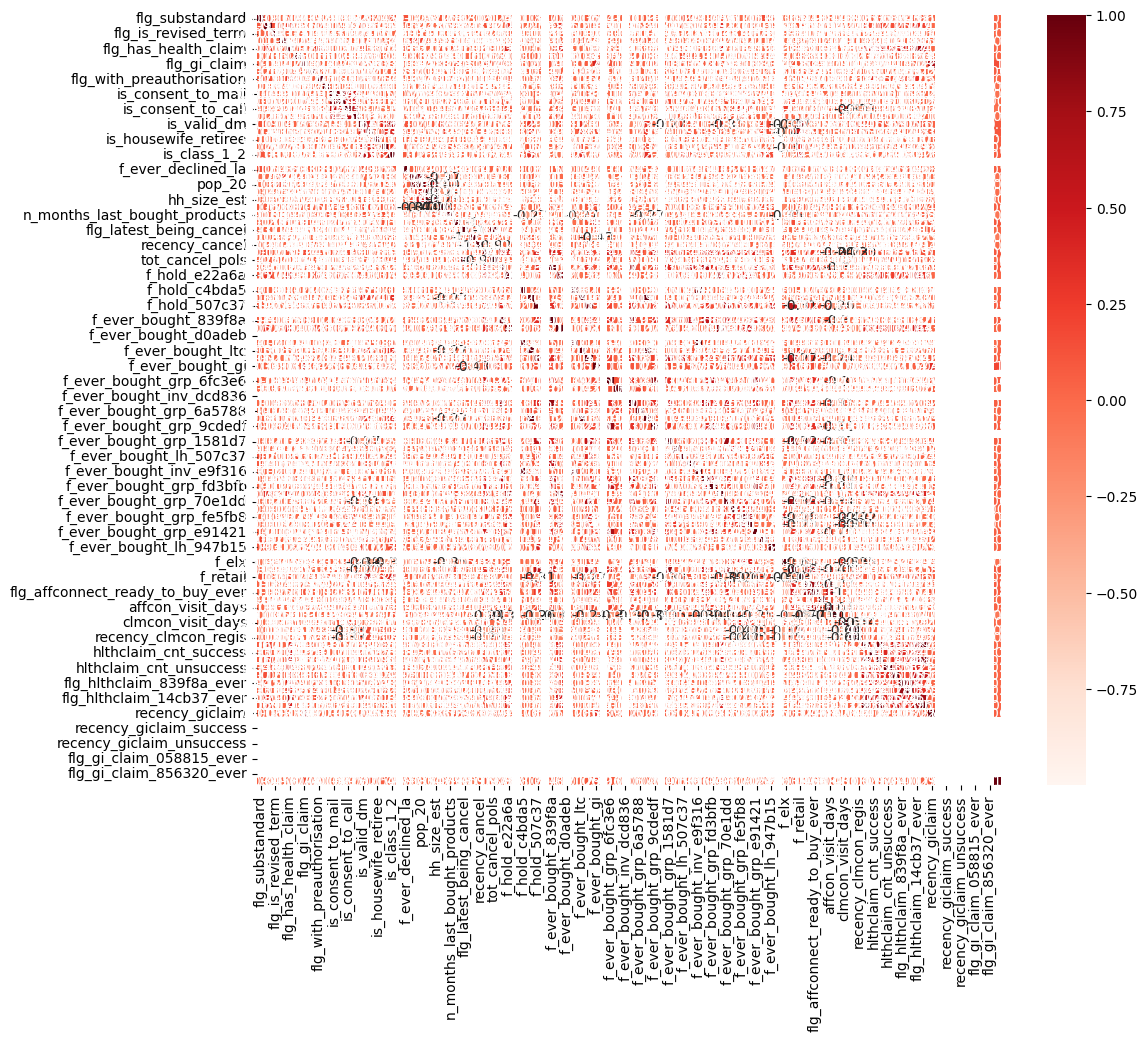

flg_gi_claim        0.141924
is_valid_dm         0.100784
is_valid_email      0.103897
f_ever_bought_gi    0.194966
f_purchase_lh       1.000000
Name: f_purchase_lh, dtype: float64

In [83]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#Correlation with output variable
cor_target = abs(cor['f_purchase_lh'])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1]
relevant_features

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [ ]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    result = [] 
    return result

##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

[]


### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!